In [1]:
from klkmeans import kl_kMeans

In [2]:
from helper import calculate_likelihood_em

In [5]:
from sklearn.externals import joblib
import pandas as pd

onlineEM = joblib.load('pkl/onlineEM_15_days_7_alligned.pkl')
"""test1 = joblib.load('pkl/groupped_data_15_days_00001_04320.pkl')
test2 = joblib.load('pkl/groupped_data_15_days_04321_08640.pkl')
test3 = joblib.load('pkl/groupped_data_15_days_08641_12960.pkl')
test4 = joblib.load('pkl/groupped_data_15_days_12961_17280.pkl')
groupped_data = pd.concat([test1, test2, test3, test4])
groupped_data1 = joblib.load('pkl/groupped_data_15_days_17281_21600.pkl')"""

"test1 = joblib.load('pkl/groupped_data_15_days_00001_04320.pkl')\ntest2 = joblib.load('pkl/groupped_data_15_days_04321_08640.pkl')\ntest3 = joblib.load('pkl/groupped_data_15_days_08641_12960.pkl')\ntest4 = joblib.load('pkl/groupped_data_15_days_12961_17280.pkl')\ngroupped_data = pd.concat([test1, test2, test3, test4])\ngroupped_data1 = joblib.load('pkl/groupped_data_15_days_17281_21600.pkl')"

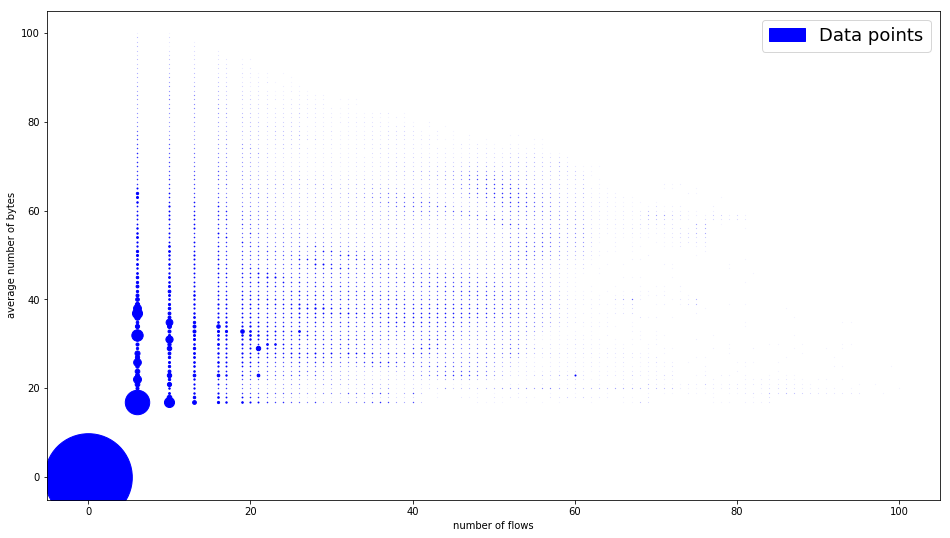

In [4]:
from plots import plot_points
%matplotlib inline

plot_points(groupped_data.values[:,:2])

Should this be done?

for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for l in  tm:
        l[l==0] = 0.00001

Or this?

for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, point in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        if point == 0:
            tm[i] = np.zeros(onlineEM.m)

In [6]:
# Percentage of times each states leads to the same state
# Approximately

total = 0
same = 0

total_except_zero = 0
same_except_zero = 0
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    points_per_cluster = onlineEM.hosts[host]['points_per_cluster']
    total += sum(points_per_cluster)
    total_except_zero += sum(points_per_cluster[1:])
    i = 0
    for p, tvector in zip(points_per_cluster, tm):
        same += tm[i][i] * p
        if i != 0:
            same_except_zero += tm[i][i] * p
        i += 1

    
print('Percentage of times the next state is the same of the previous' , same / total * 100, '%')
print('Percentage of times the next state is the same of the previous not regarding zero traffic', 
      same_except_zero / total_except_zero * 100, '%')

Percentage of times the next state is the same of the previous 70.4634250851 %
Percentage of times the next state is the same of the previous not regarding zero traffic 29.4609448236 %


Initialize hmm 

In [7]:
import numpy as np

m = onlineEM.m

initialize = np.eye(m)

for i in range(m):
    for j in range(m):
        if i != j:
            initialize[i][j] = 0.5
            
    initialize[i] /= (1 + 0.5 * (m - 1))

In [8]:
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, points in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)

Running the kmeans algorithm

In [8]:
from sklearn.externals import joblib

kmeans = joblib.load('pkl/kmeans_20.pkl')

In [9]:
import matplotlib.pyplot as plt 
from pylab import rcParams

rcParams['font.size'] = 16

### Categorize hosts

In [10]:
from klkmeans import hmm_distance

distances = []
for host in onlineEM.hosts:
    distances.append([host, hmm_distance(onlineEM.hosts[host]['transition_matrix'], kmeans.centers[kmeans.assignments[host]])])

In [11]:
from plots import plot_points_host

#### Here are the mst anomalous hosts

In [12]:
# hosts with the higher distance respective to their kmeans center
sorted(distances, key=lambda x: -x[1])[:10]

[['C1707', 1.7051670894383775],
 ['C1340', 1.5959731796300325],
 ['C1685', 1.5745774161843291],
 ['C473', 1.518958103505321],
 ['C4797', 1.3216267658867458],
 ['C23382', 1.2934107098694947],
 ['C202', 1.2741782683274805],
 ['C2986', 1.2550163842597701],
 ['C5089', 1.2403861447370224],
 ['C5713', 1.205160791384323]]

In [13]:
#find best parameters!!!

def find_percentage(sorted_distances, every=range(10,100,10)):
    total = len(sorted_distances)
    distances = {}
    for k in every:
        distances[k] = sorted_distances[1 - int(total*k/100)][1]
    return distances

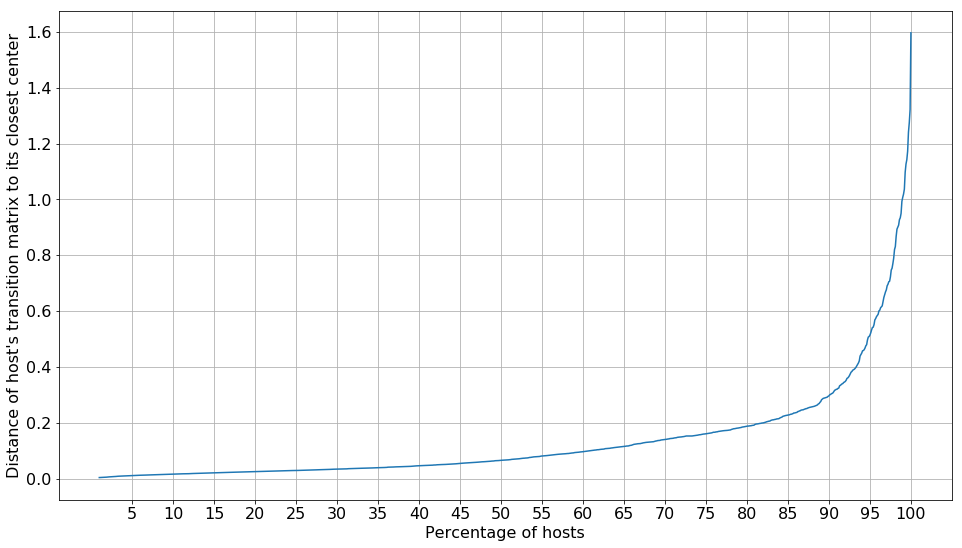

In [14]:
from pylab import rcParams
from matplotlib import pyplot as plt

colors = ['blue', 'red', 'green', 'yellow', 'black']
rcParams['font.size'] = 16
rcParams['figure.figsize'] = 16, 9

sorted_distances = sorted(distances, key=lambda x: -x[1])

ranges = np.arange(1,100.1,0.1)
show_ranges = range(5,101,5)

percentages = list(find_percentage(sorted_distances, every=ranges).values())
  
plt.plot(list(ranges), percentages)
plt.xlabel('Percentage of hosts')
plt.ylabel('Distance of host\'s transition matrix to its closest center')
plt.xticks(show_ranges)
plt.grid() 
plt.show()

In [15]:
# Find the average distances of hosts from their center in each cluster
import numpy as np
from klkmeans import hmm_distance


average_distances = {}
for k,v in kmeans.assignments.items():
    # manually inserted anomalous host
    if k.startswith("A"):
        continue
    if v in average_distances:
        average_distances[v].append(hmm_distance(onlineEM.hosts[k]['transition_matrix'], kmeans.centers[v]))
    else:
        average_distances[v] = []
        average_distances[v].append(hmm_distance(onlineEM.hosts[k]['transition_matrix'], kmeans.centers[v]))
        
for k,v in sorted(average_distances.items()):
    print('Average distances from enter  {:2d} for the hosts with this as their closest center is {:.3f}'.format(k, 
                                                                                                                 sum(v)/len(v)))

Average distances from enter   0 for the hosts with this as their closest center is 0.043
Average distances from enter   1 for the hosts with this as their closest center is 0.027
Average distances from enter   2 for the hosts with this as their closest center is 0.144
Average distances from enter   3 for the hosts with this as their closest center is 0.041
Average distances from enter   4 for the hosts with this as their closest center is 0.510
Average distances from enter   5 for the hosts with this as their closest center is 0.200
Average distances from enter   6 for the hosts with this as their closest center is 0.204
Average distances from enter   7 for the hosts with this as their closest center is 0.643
Average distances from enter   8 for the hosts with this as their closest center is 0.205
Average distances from enter   9 for the hosts with this as their closest center is 0.737
Average distances from enter  10 for the hosts with this as their closest center is 0.798
Average di

In [16]:
from pylab import rcParams
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.patches as mpatches

import seaborn as sns

colors = ['blue', 'red', 'green', 'yellow']
styles = ['-','--',':','-.']
rcParams['font.size'] = 16

def plot_points_host(data, hostData=None, em=None):
    rcParams['figure.figsize'] = 16, 9
    data_hashable = [tuple(x) for x in data]
    total_points = len(data_hashable) / 10000

    values = np.vstack([list(x) for x in list(Counter(data_hashable).keys())])
    counts = np.array(list(Counter(data_hashable).values()))

    for i in range(len(values)):
        plt.scatter(values[i][0], values[i][1], s=counts[i]/total_points, color='blue')
        
    patches=[mpatches.Patch(color='blue', label='Data points')]
    
    if hostData is not None:    
        data_hashable = [tuple(x) for x in hostData]
        total_points = len(data_hashable) / 100

        values = np.vstack([list(x) for x in list(Counter(data_hashable).keys())])
        counts = np.array(list(Counter(data_hashable).values()))
        for i in range(len(values)):
            plt.scatter(values[i][0], values[i][1], s=counts[i]*100/total_points, color='orange')
            
        patches.append(mpatches.Patch(color='orange', label='Host data'))
        
    if em is not None:
        for i, lambda_i in enumerate(em.lambdas):
            plt.scatter(lambda_i[0], lambda_i[1], s=em.gammas[i]*2500, linewidth=4, color='red', marker='x')

        patches.append(mpatches.Patch(color='red', label='Distribution centers'))
    
    plt.legend(handles=patches, fontsize=18)
    plt.ylabel('average number of bytes')
    plt.xlabel('number of flows')
    plt.show()

Host C1707 has the most anomalous behavior


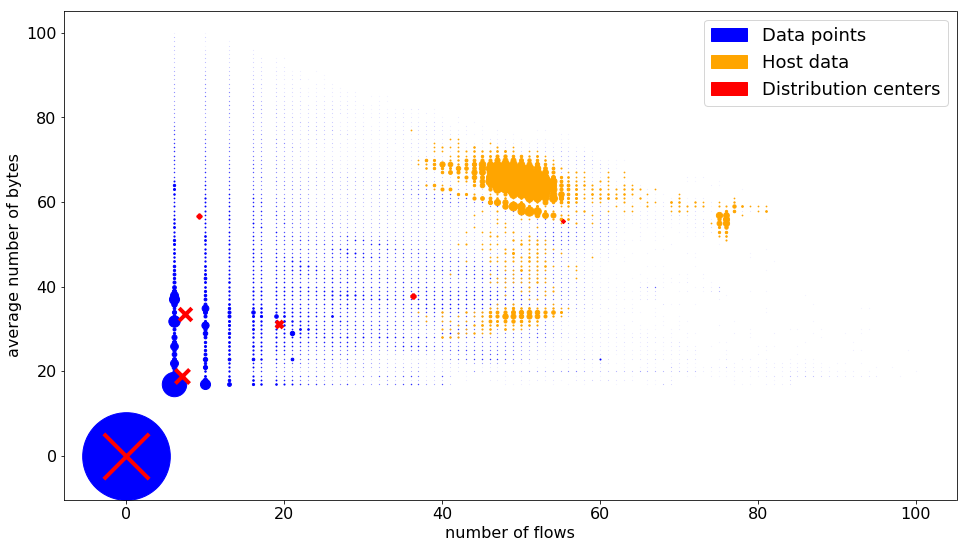

In [17]:
host = sorted_distances[0][0]
print('Host', host, 'has the most anomalous behavior')
plot_points_host(groupped_data.values[:, :2], hostData=groupped_data[groupped_data['source computer'] == host].values[:, :2],
                em=onlineEM)

In [18]:
from pylab import rcParams
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.patches as mpatches

import seaborn as sns


colors = ['blue', 'red', 'green', 'yellow']
styles = ['-','--',':','-.']
rcParams['font.size'] = 16
# HOST and clusters
%matplotlib inline

def plot_transition_matrix(em, kmeans, host):
    rcParams['figure.figsize'] = 16, 9

    plt.subplot(1,2,1)
    ax = sns.heatmap(em.hosts[host]['transition_matrix'])
    plt.title('Host transition matrix')
    
    plt.subplot(1,2,2)
    ax = sns.heatmap(kmeans.centers[kmeans.assignments[host]])
    plt.title('Kmeans center transition matrix for center ' + str(kmeans.assignments[host]))
    plt.show()

In [19]:
onlineEM.lambdas

array([[0.0, 0.0],
       [55.35796116568266, 55.5106133016459],
       [7.490530257660513, 33.61984253955143],
       [9.192336417675378, 56.81490528692768],
       [19.384708222786813, 31.1284045736644],
       [36.29728398378874, 37.89205204878816],
       [7.0770611843650215, 18.8042149465344]], dtype=object)

In [20]:
onlineEM.hosts[host]['points_per_cluster']

array([     0.,  16511.,      0.,      0.,      0.,    768.,      0.])

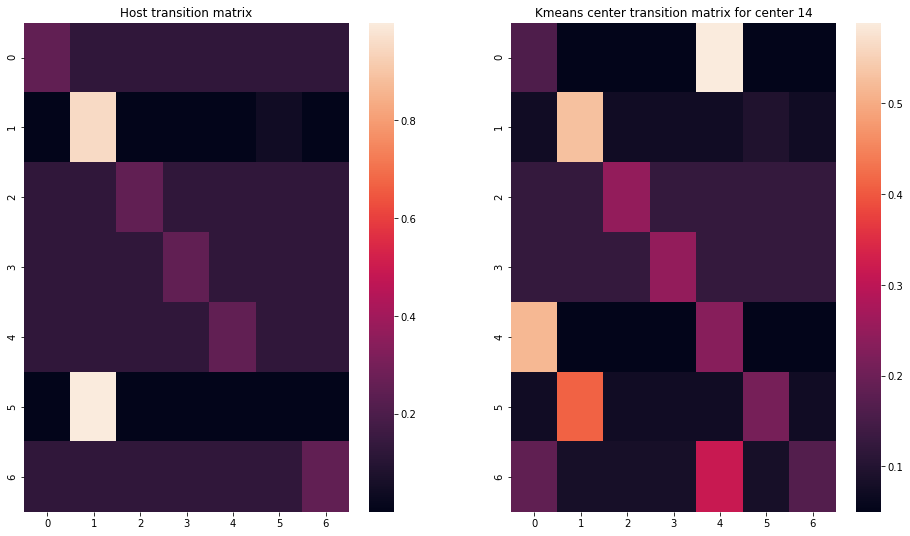

In [21]:
plot_transition_matrix(onlineEM, kmeans, host)

In [22]:
import collections
    
centers = {}
for host in onlineEM.hosts:
    if kmeans.assignments[host] in centers:
        centers[kmeans.assignments[host]] += 1 
    else:
        centers[kmeans.assignments[host]] = 1


participations = collections.OrderedDict(sorted(centers.items()))
print(participations)

OrderedDict([(0, 710), (1, 95), (2, 374), (3, 270), (4, 22), (5, 40), (6, 95), (7, 9), (8, 35), (9, 19), (10, 33), (11, 122), (12, 46), (13, 138), (14, 5), (15, 119), (16, 59), (17, 12), (18, 50), (19, 15)])


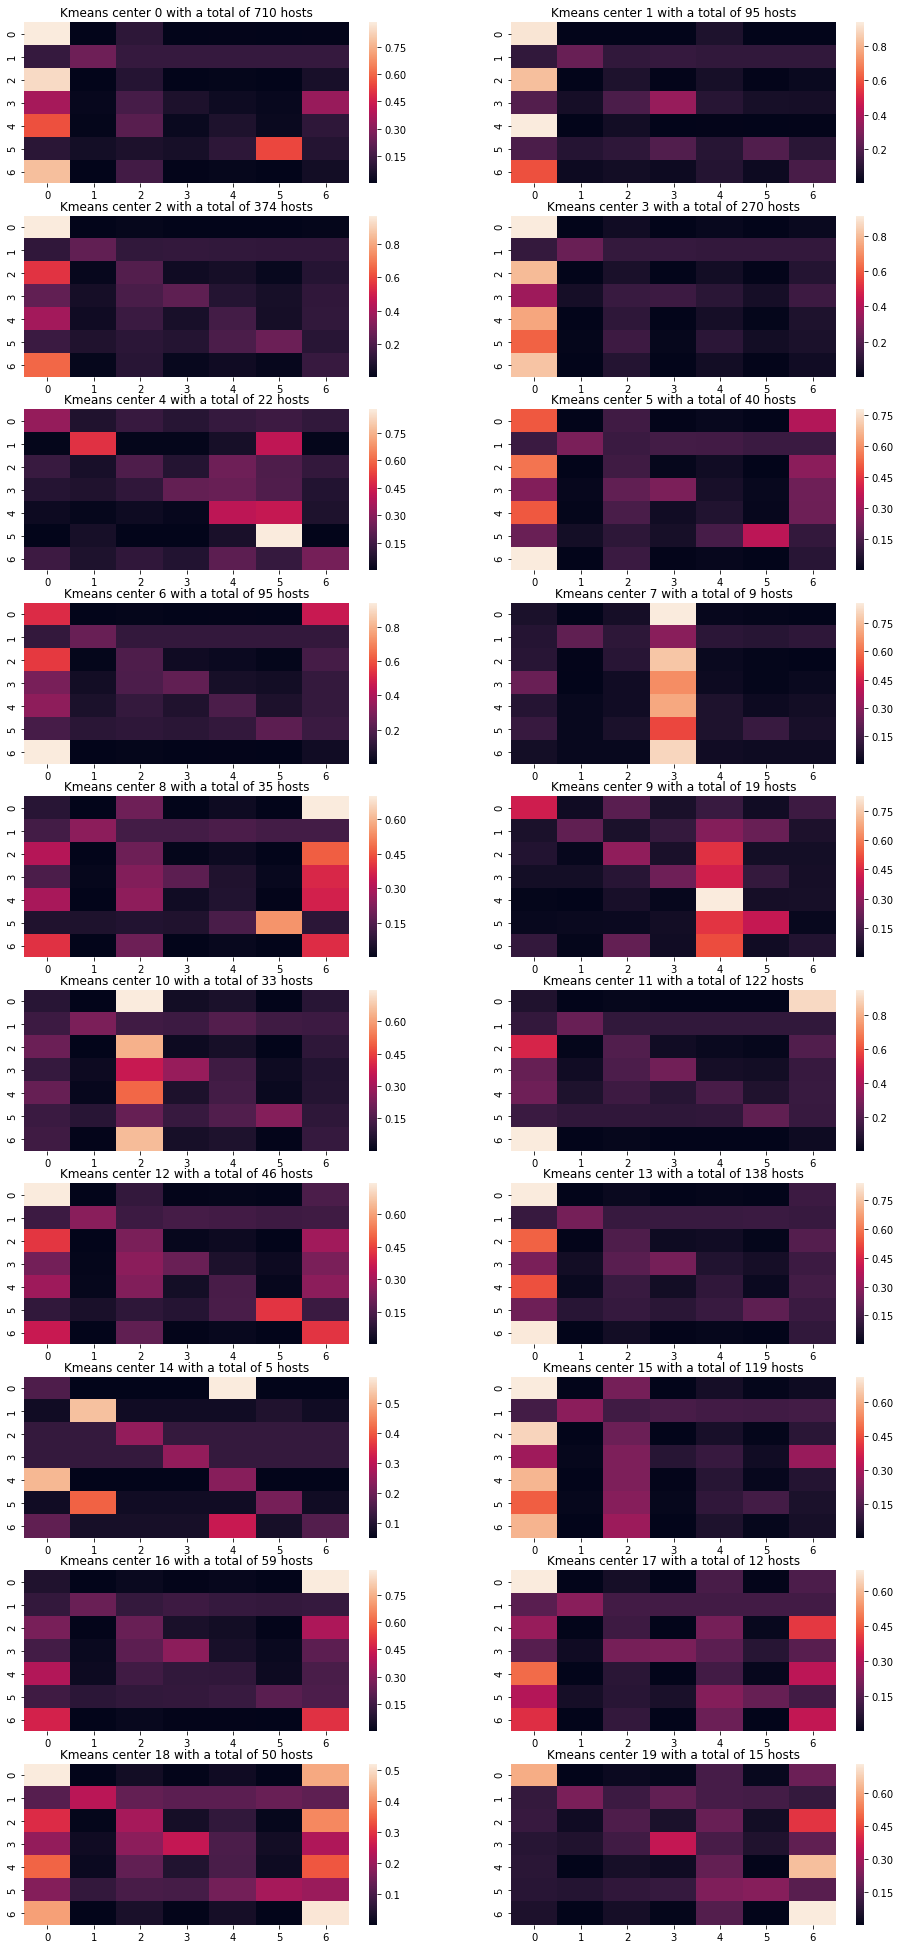

In [23]:
rcParams['figure.figsize'] = 16, 35
    

for i in range(len(kmeans.centers)):
    plt.subplot(len(kmeans.centers) / 2,2,i+1)
    ax = sns.heatmap(kmeans.centers[i])
    if i in participations:
        num = str(participations[i])
    else:
        num = str(0)
    plt.title('Kmeans center ' + str(i) + ' with a total of ' + num + ' hosts')

plt.show()

In [23]:
#calculate_likelihood_em(onlineEM, groupped_data1.values[:,[0,1,3]], kmeans, take_mean=False, weight=0.5, verbose=1)

In [24]:
#calculate_likelihood_em(onlineEM, groupped_data1.values[:,[0,1,3]], kmeans, take_mean=True, weight=0.2, verbose=1)

#### Create random traffic for a new host

In [37]:
def percentage_anomalous(sorted_distances, value):
    total = len(sorted_distances)
    values_smaller = len(np.where(np.vstack(np.array(sorted_distances, dtype=object))[:, 1] < value)[0])
    return values_smaller / total

In [39]:
import random as ran

def random_vector(size=7):
    vec = [ran.random() for i in range(size)]
    return np.array(vec) / sum(vec)

def random_transition_matrix(size=7):
    return np.vstack([random_vector(size=size) for i in range(size)])

In [84]:
t = []
size = 50000

test_df = groupped_data.head(size)
epochs = 1500


for i in range(30):
    anomalous_host = 'ΒΒΒBBBΒ' + str(i)
    
    data = []
    for i in range(epochs):
        #flows = ran.randint(1,50)
        #average_bytes = ran.randint(1,50)
        values = ran.choice(test_df.values[:, :2])
        data.append([values[0], values[1], anomalous_host])

    for data_point in data:
        onlineEM.update_host(data_point)
        
    tm = onlineEM.hosts[anomalous_host]['transition_matrix']
    for i, points in enumerate(onlineEM.hosts[anomalous_host]['points_per_cluster']):
        tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)
        
    distances_for_anomalous_host = []
    for i in range(len(kmeans.centers)):
        distances_for_anomalous_host.append([i, hmm_distance(onlineEM.hosts[anomalous_host]['transition_matrix'], 
                                             kmeans.centers[i]) ])
    distances_for_anomalous_host.sort(key=lambda x: x[1])
    t.append(distances_for_anomalous_host[0][1])
    v = average_distances[distances_for_anomalous_host[0][0]]
    print(distances_for_anomalous_host[0][1], sum(v)/len(v))
    
value = sum(t)/len(t)
print('FINAL')
print(value)
print(percentage_anomalous(sorted_distances, value))

0.119278753401 0.050577241492
0.133330986629 0.157304808184
0.124930664976 0.050577241492
0.117396044595 0.050577241492
0.115069894593 0.050577241492
0.104415306093 0.050577241492
0.129064397167 0.050577241492
0.109153216245 0.050577241492
0.120556761465 0.050577241492
0.122246070395 0.050577241492
0.107826174399 0.050577241492
0.11311410602 0.050577241492
0.135790534604 0.050577241492
0.11234787049 0.050577241492
0.140681115355 0.050577241492
0.113054842115 0.050577241492
0.1151385036 0.050577241492
0.126060018437 0.050577241492
0.121034277085 0.050577241492
0.113568908246 0.050577241492
0.137653384719 0.050577241492
0.101668612589 0.050577241492
0.129863702795 0.050577241492
0.130441855636 0.050577241492
0.116671979679 0.050577241492
0.125700833122 0.050577241492
0.108041930465 0.050577241492
0.104373350144 0.050577241492
0.13836802177 0.050577241492
0.126261925936 0.050577241492
FINAL
0.120436801426
0.6578483245149912


In [24]:
# RANDOM COMBINATION OF FLOWS AND NUMBER OF BYTES
import random as ran
import random

random_flows = list(set(groupped_data['number of flows'].values))
random_average_bytes = list(set(groupped_data['mean(byte count)'].values))

anomalous_host = 'A70'
epochs = 1500

data = []
for i in range(epochs):
    #flows = ran.randint(1,50)
    #average_bytes = ran.randint(1,50)
    flows = random.choice(random_flows)
    average_bytes = random.choice(random_average_bytes)
    data.append([flows, average_bytes, anomalous_host])

    
for data_point in data:
    onlineEM.update_host(data_point)

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


In [28]:
#RANDOM VALUE ENCOUNTERED IN THE SET OF GROUPED_DATA
import random as ran
import random

size = 10000

test_df = groupped_data.head(size)
unique_values = np.vstack({tuple(row) for row in test_df.values[:,:2]})

anomalous_host = 'A71'
epochs = 1500

data = []
for i in range(epochs):
    values = random.choice(unique_values)
    data.append([values[0], values[1], anomalous_host])

    
for data_point in data:
    onlineEM.update_host(data_point)

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


In [32]:
#RANDOM VALUE ENCOUNTERED IN GROUPED_DATA
import random as ran
import random

size = 10000

test_df = groupped_data.head(size)

anomalous_host = 'A72'
epochs = 1500

data = []
for i in range(epochs):
    values = random.choice(test_df.values[:,:2])
    data.append([values[0], values[1], anomalous_host])

    
for data_point in data:
    onlineEM.update_host(data_point)

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


In [33]:
tm = onlineEM.hosts[anomalous_host]['transition_matrix']
for i, points in enumerate(onlineEM.hosts[anomalous_host]['points_per_cluster']):
    tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)

In [34]:
distances_for_anomalous_host = []
for i in range(len(kmeans.centers)):
    distances_for_anomalous_host.append([i, hmm_distance(onlineEM.hosts[anomalous_host]['transition_matrix'], 
                                         kmeans.centers[i]) ])

In [35]:
distances_for_anomalous_host.sort(key=lambda x: x[1])
distances_for_anomalous_host

[[3, 0.07594367164013742],
 [13, 0.15742292383144041],
 [0, 0.17211190712666144],
 [2, 0.24963728648976027],
 [15, 0.29641748892217945],
 [12, 0.38351386052124081],
 [1, 0.53552501016223564],
 [5, 0.5909416521679044],
 [17, 0.60099432249880036],
 [6, 0.92352738734460282],
 [18, 1.0140290802992937],
 [19, 1.8545637571574309],
 [8, 2.5892262877276466],
 [14, 2.6157738439498646],
 [16, 2.92275646431548],
 [11, 2.9417029302224895],
 [10, 3.0533256954410679],
 [9, 3.0713893331911652],
 [4, 3.5127224048885162],
 [7, 4.6092680408622169]]

In [150]:
onlineEM.hosts[anomalous_host]['points_per_cluster']

array([  1.23900000e+03,   1.00000000e+00,   1.07000000e+02,
         2.00000000e+00,   3.80000000e+01,   7.00000000e+00,
         1.05000000e+02])

In [153]:
kmeans.assignments[anomalous_host] = distances_for_anomalous_host[0][1]

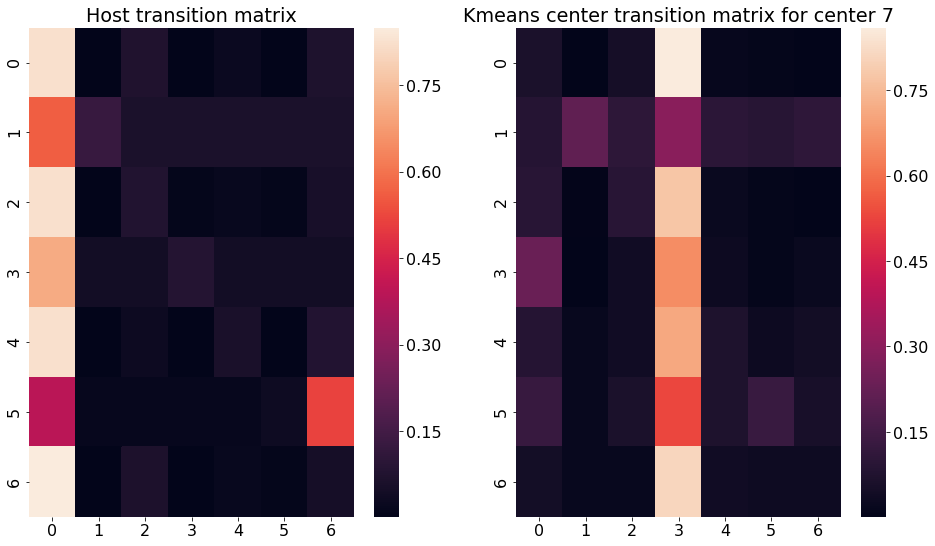

In [154]:
plot_transition_matrix(onlineEM, kmeans, anomalous_host)

## Number of clusters to choose

In [ ]:
from klkmeans import hmm_distance
import copy

results = {}
kmeans_all = {}
clusters = list(range(31,41))
for n_clusters in clusters:
    print('Now running fot number of clusters', n_clusters)
    kmeans = kl_kMeans(onlineEM, n_clusters=n_clusters, n_iters=15, n_runs=10)
    C, assign = kmeans.run(verbose=0, initialization='k++')
     
    distances = []
    for host in onlineEM.hosts:
        distances.append([host, hmm_distance(onlineEM.hosts[host]['transition_matrix'], kmeans.centers[assign[host]])])
        
    sorted_distances = sorted(distances, key=lambda x: -x[1])
    results[n_clusters] = sorted_distances.copy()
    kmeans_all[n_clusters] = copy.deepcopy(kmeans)

Now running fot number of clusters 31
Now running fot number of clusters 32


In [ ]:
ranges = range(10,100,5)

percentages = []
for n_clusters in clusters:
    percentages.append(list(find_percentage(results[n_clusters], every=ranges).values()))

In [ ]:
from pylab import rcParams
from matplotlib import pyplot as plt

colors = ['blue', 'red', 'green', 'yellow', 'black']
rcParams['font.size'] = 16
rcParams['figure.figsize'] = 16, 9

show_clusters = [10, 15, 20, 25, 30]
for percentage, color, n_clusters in zip(percentages, colors, show_clusters):
    plt.plot(ranges, percentage, label='Number of cluster: ' + str(n_clusters))

plt.xlabel('Percentage of hosts')
plt.ylabel('Distance of host\'s transition matric to its closest center smaller than')
plt.xticks(ranges)
plt.grid()
plt.legend()    
plt.show()

### Inertia plot

In [ ]:
from sklearn.externals import joblib

joblib.dump(kmeans_all, 'kmeans_all1.pkl')
#kmeans_all = joblib.load('kmeans_all.pkl')

In [37]:
from klkmeans import hmm_distance

results = {}
for n_clusters, kmeans in kmeans_all.items():
    distances = []
    for host in onlineEM.hosts:
        distances.append(hmm_distance(onlineEM.hosts[host]['transition_matrix'], kmeans.centers[kmeans.assignments[host]]))
        
    sorted_distances = sorted(distances)
    results[n_clusters] = sorted_distances.copy()
    
    #print(kmeans._cost(kmeans.centers, kmeans.assignments))

In [ ]:
# OLD SILHOUETTE !!!!!!!!!!!!!!!!!!!!

from sklearn.metrics import silhouette_score
from klkmeans import hmm_distance

sil = []
for n_clusters, kmeans in kmeans_all.items():
    means_intra_distances = {}
    for i in range(len(kmeans.centers)):
        matrices = kmeans._transition_matrices_for_cluster(i, kmeans.assignments)
        
        cost = 0
        for transition_matrix in matrices:
            cost += hmm_distance(transition_matrix, kmeans.centers[i])
        
        means_intra_distances[i] = cost / len(matrices)
    
    total_silhouette_score = 0
    for host in onlineEM.hosts:
        distances_for_host = []
        for i in range(len(kmeans.centers)):
            distances_for_host.append([i, hmm_distance(onlineEM.hosts[host]['transition_matrix'], 
                                                 kmeans.centers[i]) ])
        distances_for_host.sort(key=lambda x: x[1])
        
        b = distances_for_host[1][1]
        a = means_intra_distances[kmeans.assignments[host]]
        
        total_silhouette_score += (b - a) / max(a, b)
        
    
    sil.append(total_silhouette_score)
    print('kmeans', len(kmeans.centers), 'silhouette', total_silhouette_score)

"""kmeans 10 silhouette 1208.11181954
kmeans 11 silhouette 1059.74116867
kmeans 12 silhouette 1081.55146209
kmeans 13 silhouette 1131.6618338
kmeans 14 silhouette 1215.26372084
kmeans 15 silhouette 1201.73655985
kmeans 16 silhouette 1200.93941438
kmeans 17 silhouette 1220.80162766
kmeans 18 silhouette 1262.53047367
kmeans 19 silhouette 1253.53400928
kmeans 20 silhouette 1293.26855628
kmeans 21 silhouette 1237.35126978
kmeans 22 silhouette 1263.83071776
kmeans 23 silhouette 1332.39862265
kmeans 24 silhouette 1261.26918699
kmeans 25 silhouette 1109.14159873
kmeans 26 silhouette 1326.28038329
kmeans 27 silhouette 1162.17096983
kmeans 28 silhouette 1134.1026461
kmeans 29 silhouette 1347.94228013
kmeans 30 silhouette 1350.14320671"""

In [38]:
sil = np.array(sil) / len(onlineEM.hosts)

In [ ]:
for k,v in kmeans_all.items():
    print(k, v._cost(v.centers, c.assignments))

In [ ]:
from sklearn.metrics import silhouette_score
from klkmeans import hmm_distance

sil2 = []
for n_clusters, kmeans in kmeans_all.items(): 
    print('Running for n_clusters', n_clusters)
    total_silhouette_score = 0
    j = 0
    for host in onlineEM.hosts:
        j += 1
        if j % 100 == 0:
            print('Done with', j)
        
        distances = []
        for host1 in onlineEM.hosts:
            if host1 == host:
                continue
            
            distances.append([kmeans.assignments[host1], host1, hmm_distance(onlineEM.hosts[host]['transition_matrix'], 
                                                                             onlineEM.hosts[host1]['transition_matrix'])])
        
        mean_distances = np.zeros(len(kmeans.centers))
        for i in range(len(kmeans.centers)):
            total = 0
            for dis in distances:
                if dis[0] == i:
                    mean_distances[i] += dis[2]
                    total += 1
            mean_distances[i] /= total
            
        a = mean_distances[kmeans.assignments[host]]
        
        mean_distances[kmeans.assignments[host]] = 1000000
        b = np.min(mean_distances)
        
        total_silhouette_score += (b - a) / max(a, b)
            
    sil2.append(total_silhouette_score)
    print('kmeans', len(kmeans.centers), 'silhouette', total_silhouette_score)
    
sil2 = np.array(sil2)

In [ ]:
sil2 /= len(onlineEM.hosts)

In [ ]:
sil2

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 16, 9
rcParams['font.size'] = 15


inertia = []
show_clusters = list(range(31, 36))

for n_clusters in show_clusters:
    distances = results[n_clusters]
    inertia.append(sum(distances))

plt.subplot(1,2,1)

plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.xticks(list(range(10, 31, 2)))
plt.grid()
plt.plot(show_clusters, inertia)


plt.subplot(1,2,2)
plt.xlabel('Number of clusters')
plt.ylabel('silhouette coefficient')
plt.xticks(list(range(10, 31, 2)))
plt.grid()
plt.plot(show_clusters, sil2)


inertia 
[516.0401257106796,
 490.85487458092615,
 455.58151946438284,
 426.46473284606247,
 395.79055865425443,
 378.31760536199153,
 366.46021928312177,
 344.11055366530888,
 328.16435542444214,
 319.34758888484714,
 309.33765905000865,
 305.43609413450349,
 297.804206014248,
 287.96247530797791,
 281.10390338076189,
 273.47696931497944,
 265.80232022049103,
 259.85332636850319,
 256.30934835077693,
 247.74413671115235,
 244.58033646029943]
sil2
array([ 0.46079623,  0.41311649,  0.43503355,  0.438989  ,  0.41452605,
        0.4172064 ,  0.41076119,  0.41508336,  0.43803462,  0.4268199 ,
        0.44858604,  0.42502723,  0.43907296,  0.45408163,  0.43362773,
        0.39574491,  0.46941936,         nan,  0.40009537,  0.47717144,
        0.47801051])
gap
{10: 0.6230468476657807,
 11: 0.6682930749996654,
 12: 0.737601315233654,
 13: 0.7979644547944504,
 14: 0.8675576798745226,
 15: 0.9065843321860614,
 16: 0.9342895972916239,
 17: 0.9959885138728755,
 18: 1.0388356271803119,
 19: 1.062321877080871,
 20: 1.0889461247175003,
 21: 1.0997227231599194,
 22: 1.121224341183523,
 23: 1.1499415771118713,
 24: 1.1713529680328172,
 25: 1.195784474894963,
 26: 1.2219734890811607,
 27: 1.2421767252060736,
 28: 1.25087595301461,
 29: 1.2830197042060787,
 30: 1.2934067104621283}
